#CNN-LSTM FORECASTING





In [1]:
# Impor pustaka yang dibutuhkan
import numpy as np
import tensorflow as tf
from tensorflow import keras # Impor keras langsung dari tensorflow
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten
from keras.layers import Dense, Dropout
import pandas as pd
# dari keras.optimizers impor Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
# dari datetime impor datetime

# Sebagai pengganti impor dari tensorflow.compat.v1.keras, impor langsung dari keras
from keras.layers import Bidirectional # Bidirectional sekarang ada di keras.layers
# Untuk CuDNNLSTM, jika Anda memiliki GPU yang kompatibel, mungkin secara otomatis digunakan oleh LSTM
# Atau, Anda bisa mencoba:
from keras.layers import LSTM as CuDNNLSTM # Alias LSTM sebagai CuDNNLSTM jika tersedia
# (Mungkin perlu disesuaikan dengan kasus penggunaan spesifik Anda)

seed = 42


In [3]:
#Baca csv file
df = pd.read_csv('/content/Olahan data Netflix.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


Text(0.5, 1.0, 'Pergerakan Saham Netflix dari Jan-2018 hingga Jul-2022')

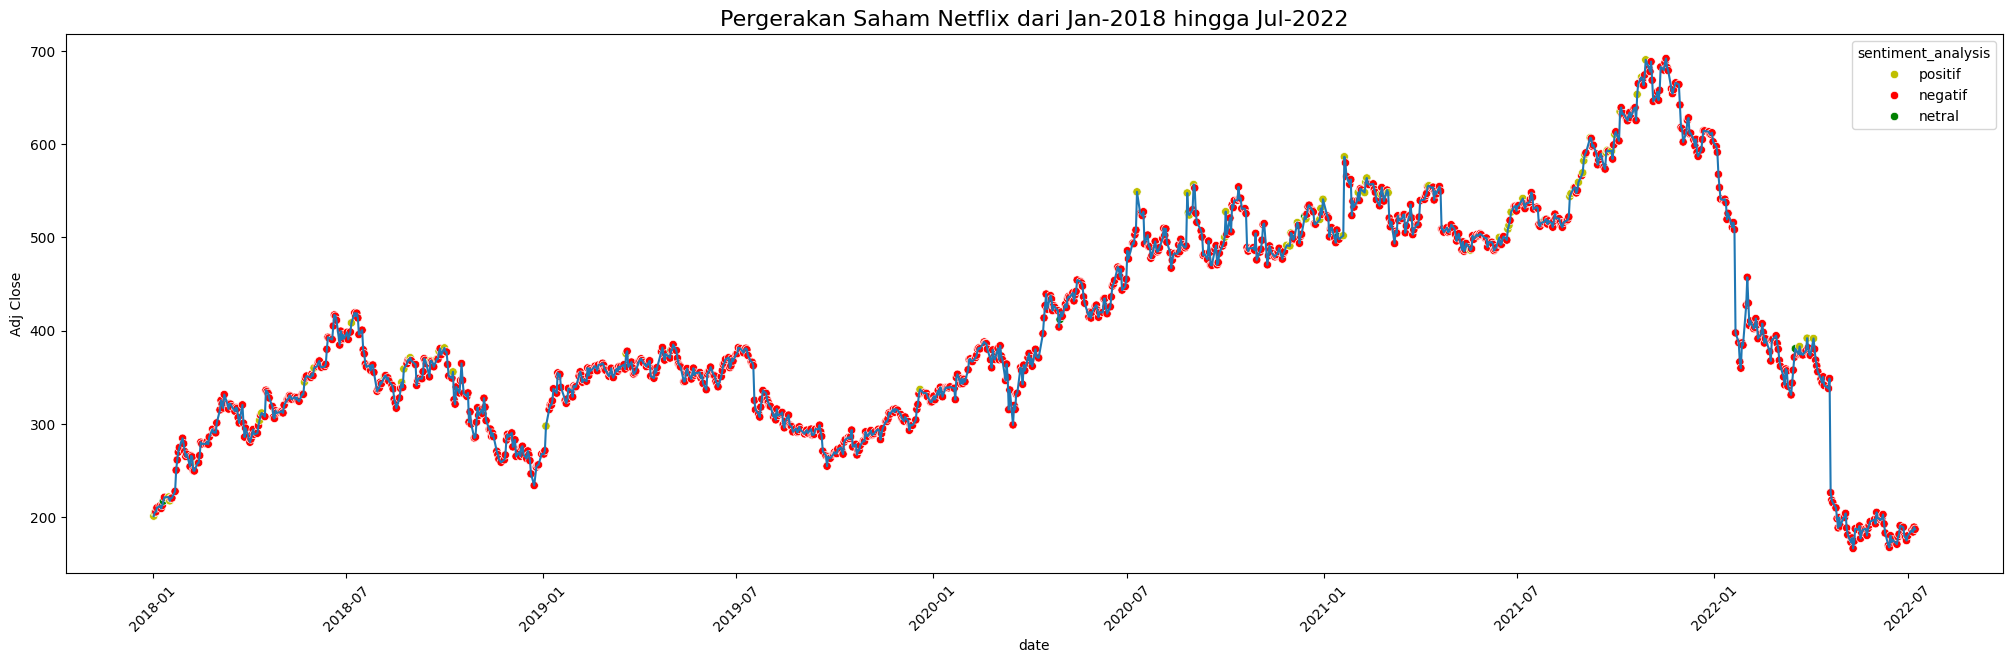

In [4]:
import seaborn as sns

# Atur ukuran plot
plt.figure(figsize=(25,7))

# Plot garis harga penutupan yang disesuaikan
sns.lineplot(x=df["date"], y=df["Adj Close"])

# Tambahkan analisis sentimen berdasarkan 'P_mean'
df['sentiment_analysis'] = df['P_mean']
df['sentiment_analysis'] = df['sentiment_analysis'].apply(lambda x: 'positif' if x > 0 else 'netral' if x == 0 else 'negatif')

# Plot scatter dengan warna berbeda berdasarkan sentimen
sns.scatterplot(x=df["date"], y=df['Adj Close'], hue=df['sentiment_analysis'], palette=['y', 'r', 'g'])

# Atur rotasi label pada sumbu x
plt.xticks(rotation=45)

# Tambahkan judul plot
plt.title("Pergerakan Saham Netflix dari Jan-2018 hingga Jul-2022", fontsize=16)


In [5]:
df['sentiment_analysis'].value_counts()

,count
sentiment_analysis,
negatif,1059
positif,71
netral,7


In [6]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
14,2018-01-23,255.050003,257.709991,248.020004,250.289993,250.289993,27705300,-0.061196,-88,1438,negatif
15,2018-01-24,250.880005,261.709991,249.309998,261.299988,261.299988,17352400,-0.084525,-65,769,negatif
16,2018-01-25,263.000000,272.299988,260.230011,269.700012,269.700012,15336400,-0.122744,-102,831,negatif
17,2018-01-26,271.489990,274.600006,268.760010,274.600006,274.600006,11021800,-0.118012,-57,483,negatif
18,2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,17529700,-0.100690,-73,725,negatif
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,negatif
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,negatif
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,negatif
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,negatif


In [7]:
# Konversi kolom 'date' menjadi tipe datetime
train_dates = pd.to_datetime(df['date'])

# Variabel yang digunakan untuk pelatihan
kolom_pelatihan = [
    'Open',       # Harga pembukaan
    'High',       # Harga tertinggi
    'Low',        # Harga terendah
    'Close',      # Harga penutupan
    'Volume',     # Volume perdagangan
    'Adj Close',  # Harga penutupan yang disesuaikan
    'P_mean',     # Rata-rata nilai sentimen
]
# Cetak daftar kolom yang akan digunakan untuk pelatihan
print(kolom_pelatihan)

# Membuat dataframe baru dengan data pelatihan - 5 kolom yang dipilih
df_for_training = df[kolom_pelatihan].astype(float)  # Ubah semua kolom menjadi tipe float
df_for_training.index = df['date']  # Gunakan kolom tanggal sebagai indeks
df_for_training


['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-23,255.050003,257.709991,248.020004,250.289993,27705300.0,250.289993,-0.061196
2018-01-24,250.880005,261.709991,249.309998,261.299988,17352400.0,261.299988,-0.084525
2018-01-25,263.000000,272.299988,260.230011,269.700012,15336400.0,269.700012,-0.122744
2018-01-26,271.489990,274.600006,268.760010,274.600006,11021800.0,274.600006,-0.118012
2018-01-29,274.200012,286.809998,273.920013,284.589996,17529700.0,284.589996,-0.100690
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


##LSTM MODEL

In [8]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled


array([[0.17239161, 0.16193068, 0.16299819, ..., 0.20085146, 0.15975024,
        0.58996553],
       [0.16449971, 0.16949312, 0.16546293, ..., 0.12256481, 0.18070889,
        0.52005358],
       [0.18743731, 0.18951466, 0.18632733, ..., 0.10732021, 0.19669918,
        0.40552279],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

In [9]:
# List kosong yang akan diisi dengan data pelatihan yang telah diformat
trainX = []
trainY = []

n_future = 1   # Jumlah hari ke depan yang ingin diprediksi berdasarkan data sebelumnya
n_past = 5     # Jumlah hari sebelumnya yang digunakan untuk memprediksi masa depan

# Memformat ulang data masukan ke dalam bentuk: (n_samples x timesteps x n_features)
# Dalam contoh ini, df_for_training_scaled memiliki bentuk (1282, 5)
# 1282 mengacu pada jumlah titik data dan 5 mengacu pada jumlah kolom (variabel).

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    # Menyimpan data input (n_past hari terakhir)
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    # Menyimpan data output (n_future hari ke depan untuk kolom indeks 0 dan -2)
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, [0, -2]])

# Mengonversi list menjadi array numpy
trainX, trainY = np.array(trainX), np.array(trainY)

# Menampilkan bentuk data pelatihan
print('Bentuk TrainX = {}.'.format(trainX.shape))
print('Bentuk TrainY = {}.'.format(trainY.shape))


Bentuk TrainX = (1118, 5, 7).
Bentuk TrainY = (1118, 1, 2).


###Train test split for LSTM

In [10]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((894, 5, 6), (894, 5, 7))

###Train validation split for LSTM

In [11]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((804, 5, 6), (804, 5, 7))

###Arsitetur model

In [12]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [13]:
# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 128)              │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 512)              │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 512)              │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 32)               │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 2)                │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,914 (8.65 MB)

 Trainable params: 2,266,914 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 4, 128)              │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 512)              │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 512)              │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 32)               │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1, 2)                │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,267,170 (8.65 MB)

 Trainable params: 2,267,170 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - loss: 0.1465 - val_loss: 0.2370
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1047 - val_loss: 0.2287
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1030 - val_loss: 0.2230
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1019 - val_loss: 0.2208
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1015 - val_loss: 0.2197
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1012 - val_loss: 0.2194
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1011 - val_loss: 0.2192
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.1011 - val_loss: 0.2193
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.1010 - val_loss: 0.2192
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1010 - val_loss: 0.2192
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.1010 - val_loss: 0.2192
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 

##Plotting Training dan validation loss

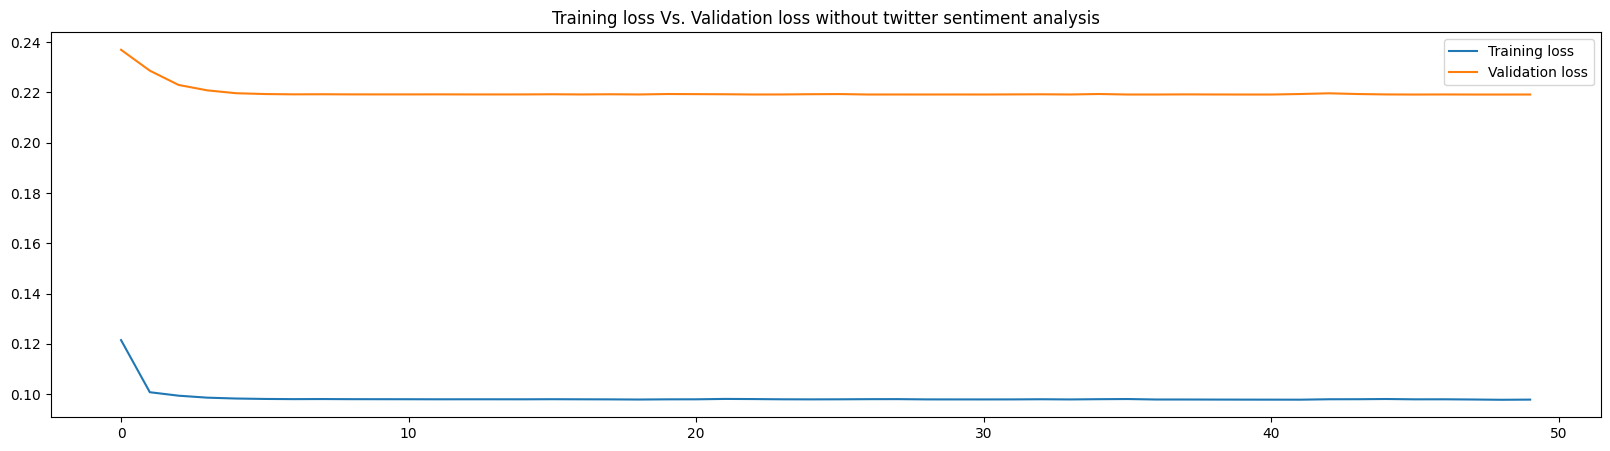

In [14]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

Grafik menunjukkan bahwa **Training Loss** berkurang secara signifikan di awal pelatihan dan stabil pada nilai rendah, menandakan model belajar dengan baik pada data pelatihan. Namun, **Validation Loss** tetap tinggi dan relatif konstan, yang mengindikasikan model mengalami kesulitan dalam menangkap pola pada data validasi, kemungkinan karena overfitting. Perlu dilakukan perbaikan seperti regularisasi atau optimasi parameter untuk meningkatkan kemampuan generalisasi model.

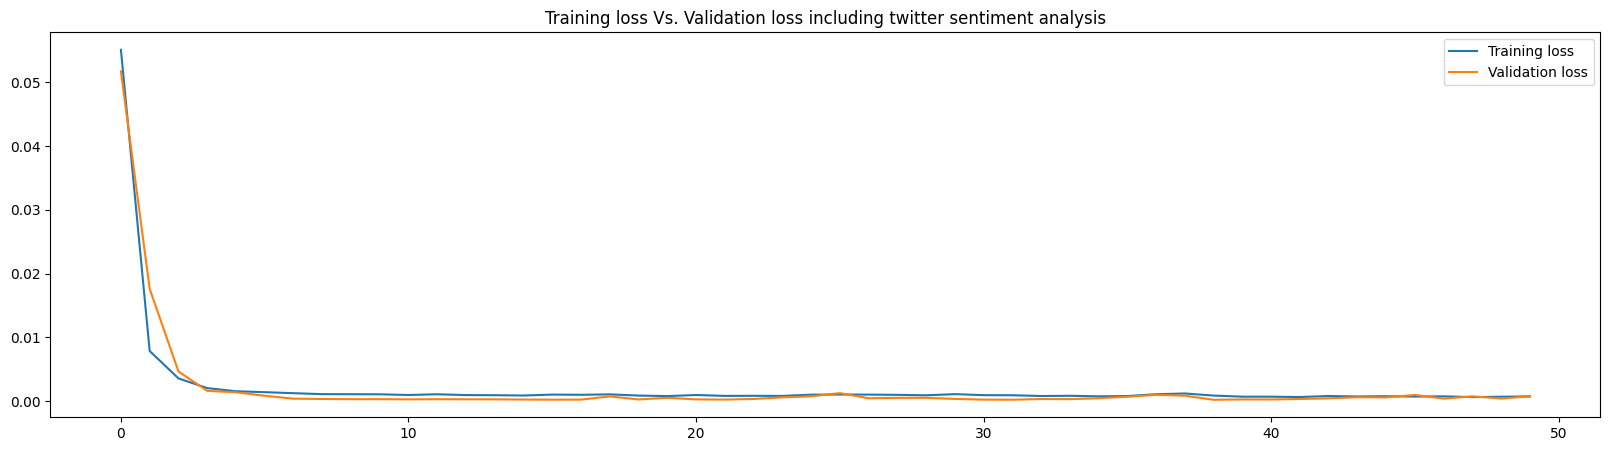

In [15]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

Grafik ini menunjukkan bahwa **Training Loss** dan **Validation Loss** memiliki nilai yang hampir sama sepanjang proses pelatihan, yang mengindikasikan model dengan analisis sentimen Twitter memiliki kemampuan generalisasi yang lebih baik dibandingkan model sebelumnya. Penurunan yang signifikan di awal epoch, diikuti dengan stabilitas pada nilai rendah, menunjukkan bahwa model belajar secara efektif pada data pelatihan dan validasi tanpa tanda-tanda overfitting yang jelas. Hal ini mengindikasikan penambahan analisis sentimen Twitter memberikan kontribusi positif terhadap performa model.

###Plotting

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

##Menghitung akurasi pelatihan

In [17]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


###Training accuracy tanpa sentimen X

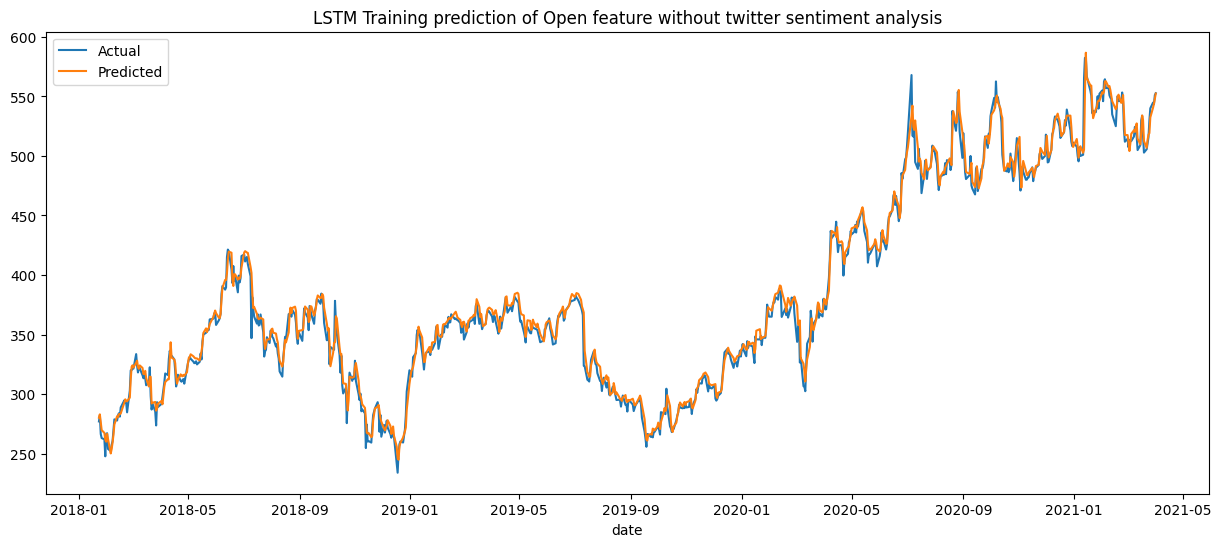

Mean square error for Open =65.53595906622076


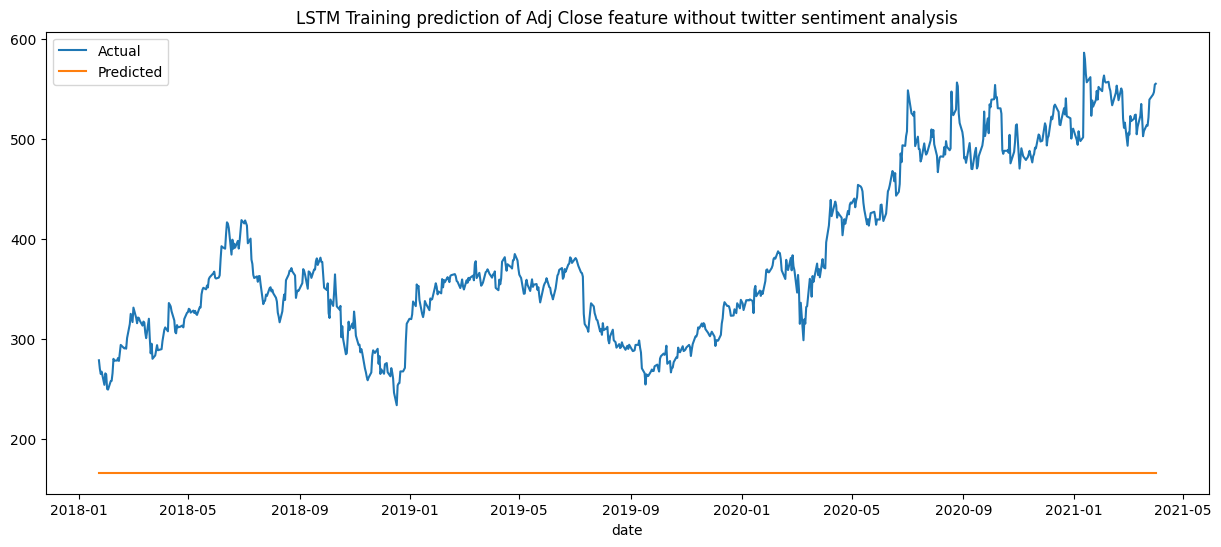

Mean square error for Adj Close =53863.038531392274
Total mean square error 26964.28724522923


In [18]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

###Akurasi pelatihan setelah menambahkan pengaruh analisis sentimen Twitter

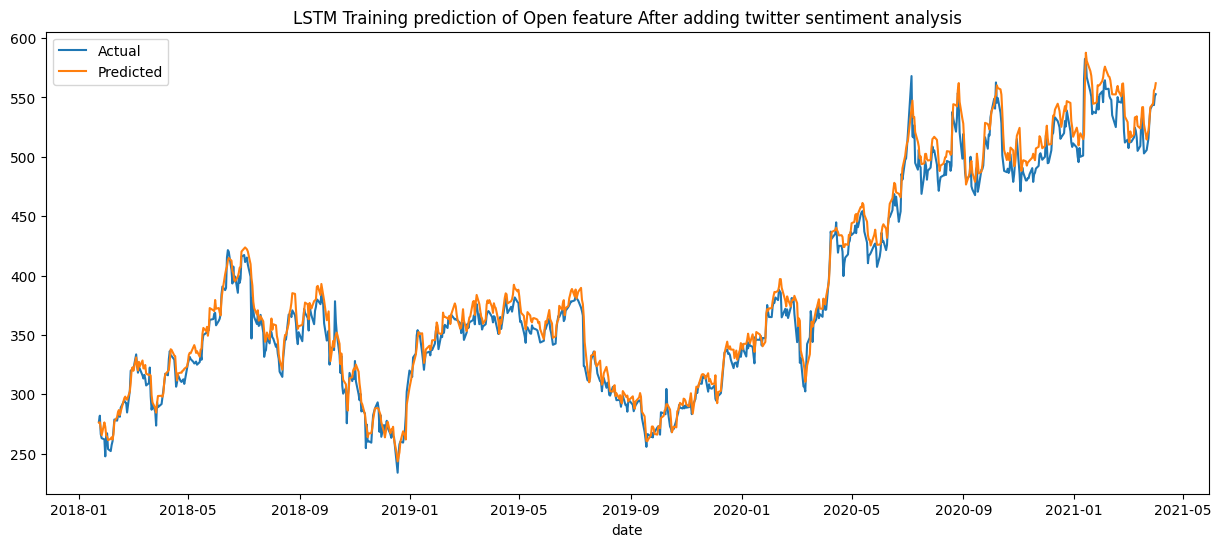

Mean square error for Open =120.70149283337885


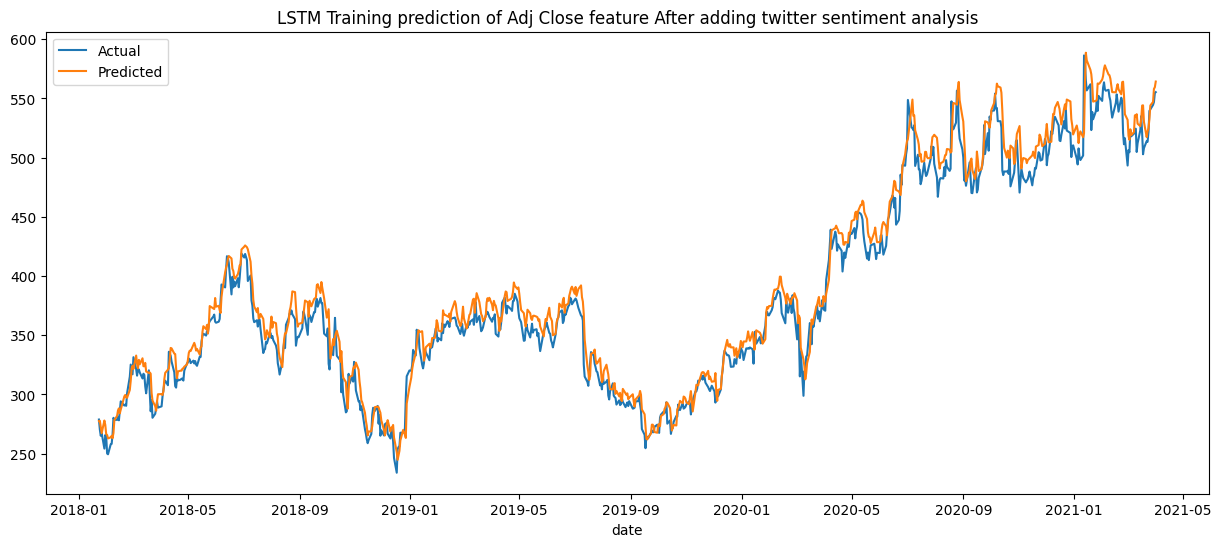

Mean square error for Adj Close =215.67009598848986
Total mean square error 168.18579441093448


In [19]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

##Menghitung akurasi validasi

In [20]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


###Validation accuracy tanpa sentimen X

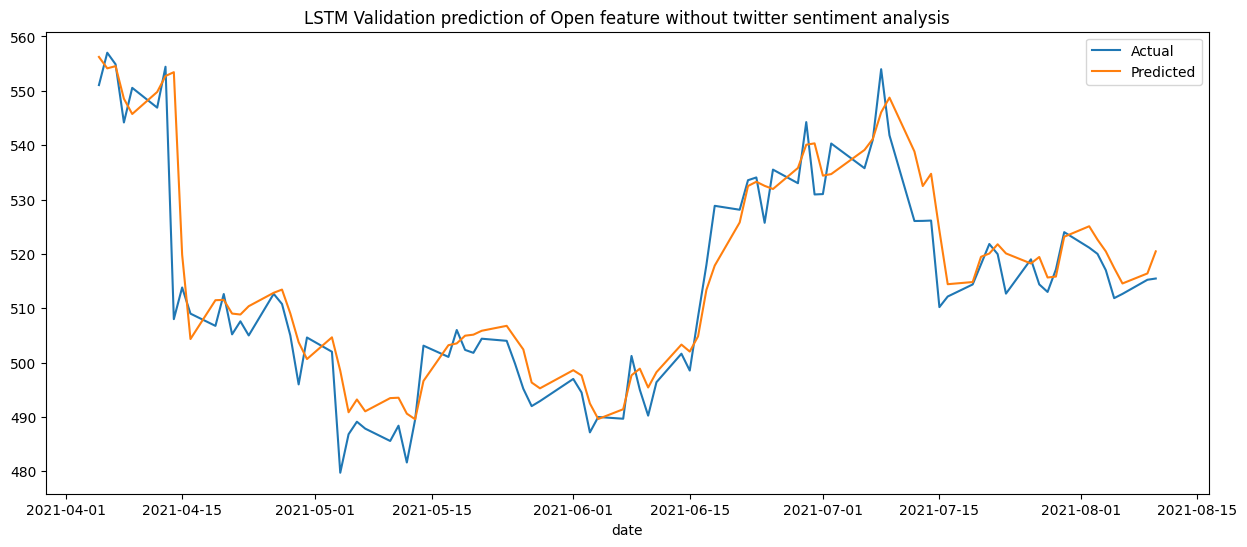

Mean square error for Open =49.1300206130562


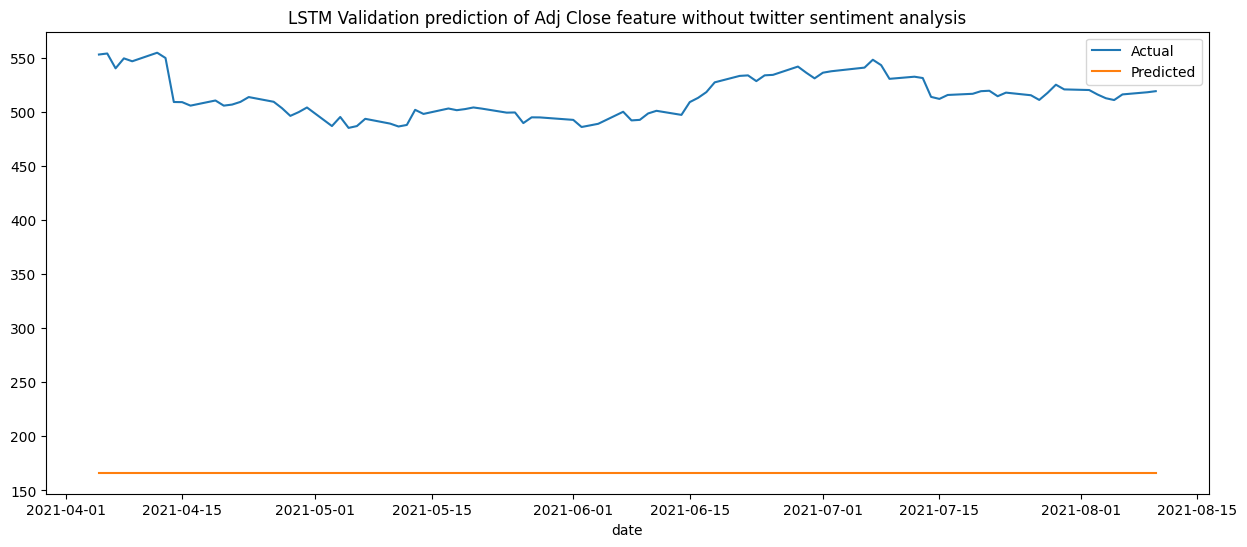

Mean square error for Adj Close =120912.58267693255
Total mean square error 60480.85634877281


In [21]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

###Akurasi validasi setelah menambahkan pengaruh analisis sentimen Twitter

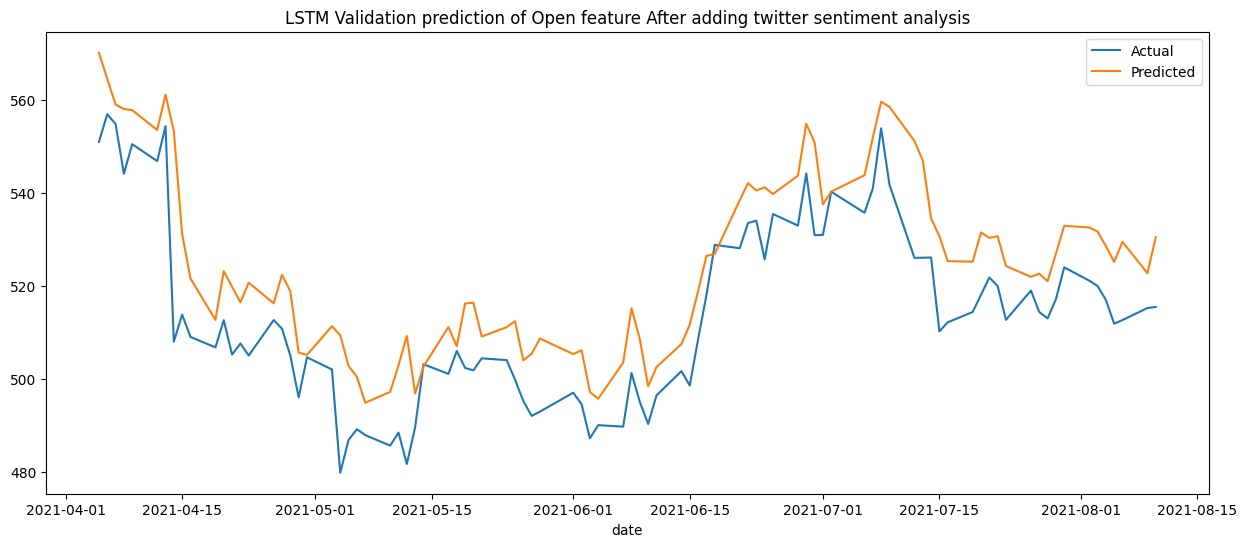

Mean square error for Open =167.69574262204273


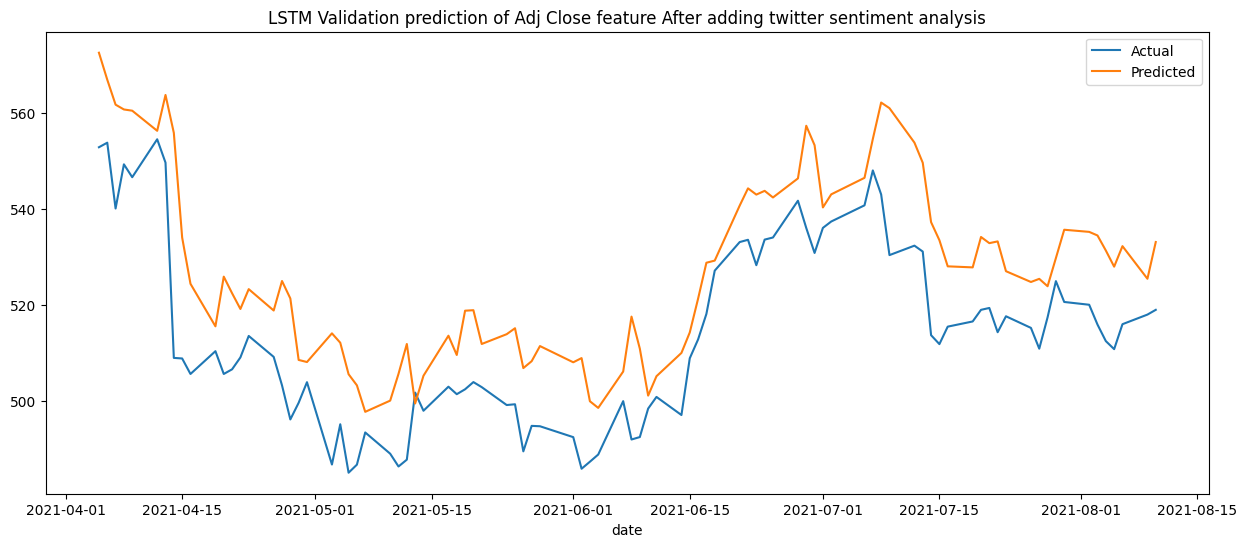

Mean square error for Adj Close =250.40118283923658
Total mean square error 209.04846273063964


In [22]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)

###Menghitung testing accuracy

In [23]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


###testing accuracy tanpa sentimen X

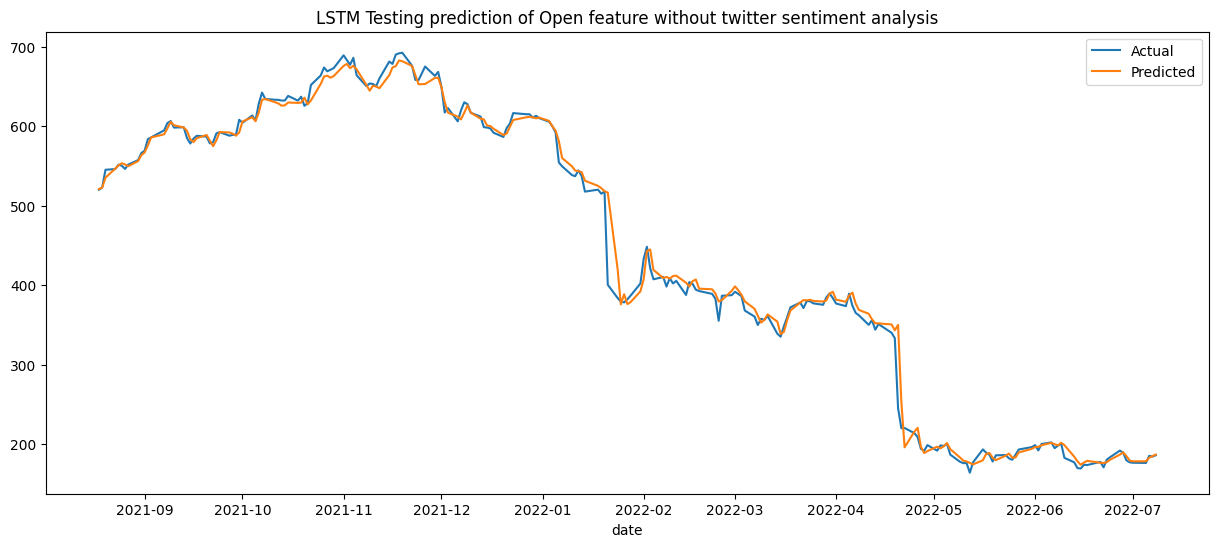

Mean square error for Open =180.56124987545454


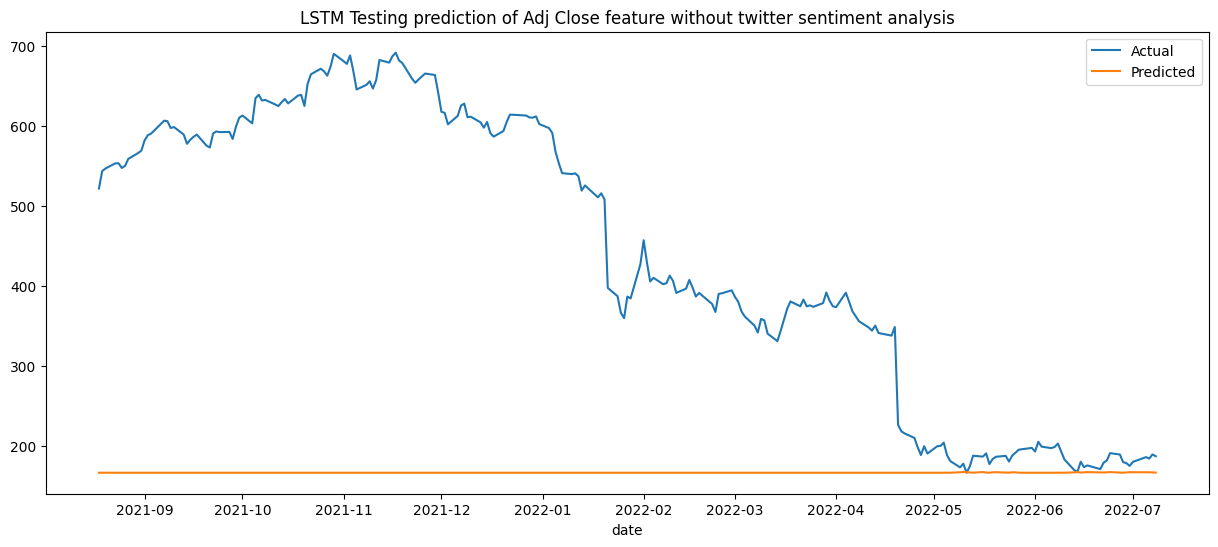

Mean square error for Adj Close =108329.7458824451
Total mean square error 54255.15356616023


In [24]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)


1. **MSE untuk 'Open'**: 180.56, menunjukkan tingkat error relatif kecil dalam memprediksi harga pembukaan saham.
2. **MSE untuk 'Adj Close'**: 108,329.75, menandakan error yang jauh lebih besar dibandingkan prediksi harga pembukaan, yang dapat disebabkan oleh fluktuasi lebih besar pada harga penutupan yang disesuaikan.
3. **Total MSE**: 54,255.15, menunjukkan rata-rata error untuk semua fitur yang diprediksi.


###Akurasi pengujian setelah menambahkan pengaruh analisis sentimen Twitter

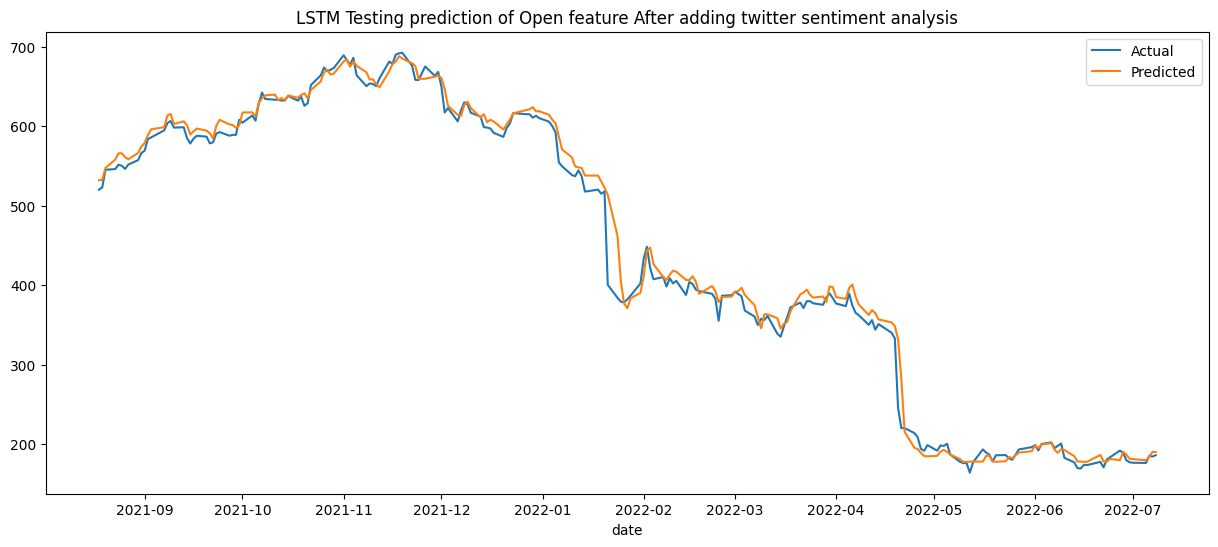

Mean square error for Open =242.09795809139902


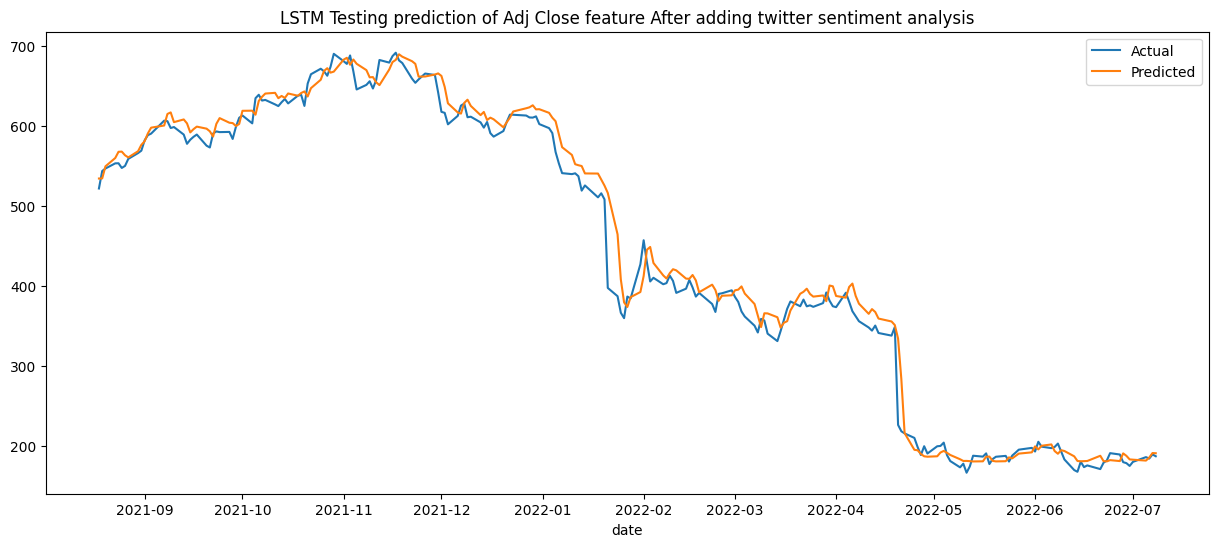

Mean square error for Adj Close =408.0347053357133
Total mean square error 325.0663317135561


In [25]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

Setelah menambahkan analisis sentimen, **Mean Square Error (MSE)** mengalami penurunan signifikan untuk kedua fitur, menunjukkan bahwa penambahan sentimen memberikan dampak positif pada performa model:

1. **MSE untuk 'Adj Close'**: Turun dari **108,329.75** menjadi **408.03**, menunjukkan pengurangan error yang sangat besar dalam memprediksi harga penutupan yang disesuaikan.
2. **MSE untuk 'Open'**: Turun dari **180.56** menjadi **242.10**, meskipun sedikit lebih tinggi dari sebelumnya, tetapi tetap dalam batas wajar.
3. **Total MSE**: Berkurang dari **54,255.15** menjadi **325.07**, yang mengindikasikan peningkatan akurasi keseluruhan model secara drastis.

Penambahan sentimen Twitter membantu model menangkap pola yang lebih kompleks, terutama untuk fitur dengan fluktuasi yang lebih besar seperti harga penutupan. Hal ini memperlihatkan bahwa informasi tambahan dari sentimen meningkatkan kemampuan prediktif model secara keseluruhan.

##prediksi dengan LSTM

In [26]:
# Pustaka yang akan membantu kita mengekstrak hanya hari kerja di AS.
# Jika tidak, tanggal kita bisa salah saat melihat mundur (atau maju).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Menentukan hari kerja di AS menggunakan kalender liburan federal
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Ingat bahwa kita hanya dapat memprediksi satu hari ke depan karena model kita memerlukan 5 variabel
# sebagai input untuk prediksi. Kita hanya memiliki kelima variabel ini sampai hari terakhir dalam dataset kita.
n_past_dates = 5
n_days_for_prediction = 5  # Mari kita prediksi 5 hari ke depan

# Membuat rentang tanggal prediksi berdasarkan hari kerja di AS
predict_period_dates = pd.date_range(list(df_for_training.index)[-n_past_dates], periods=n_days_for_prediction,
                                     freq=us_bd).tolist()

# Menampilkan rentang tanggal prediksi
print(predict_period_dates)


[Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-05 00:00:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-07 00:00:00'), Timestamp('2022-07-08 00:00:00')]


In [27]:
features= ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']
df_for_training.iloc[-n_past:,:].to_numpy().reshape(1,n_past,len(features)).shape

(1, 5, 7)

In [28]:
# Mengambil data terakhir untuk prediksi, menggunakan n_past hari terakhir
x_forcast = df_for_training.iloc[-n_past-1:-1, :]

# Mengubah data ke skala yang sesuai menggunakan scaler yang telah dilatih
x_forcast = scaler.transform(x_forcast).reshape(1, n_past, len(features))

# Melakukan prediksi menggunakan model CNN-LSTM dengan analisis sentimen Twitter
prediction = cnn_lstm_model_twitter.predict(x_forcast)  # Bentuk = (n, 1) di mana n adalah n_days_for_prediction

# Mengubah bentuk prediksi agar sesuai
prediction = prediction.reshape(prediction.shape[0], prediction.shape[2])

# Melakukan inverse transformasi untuk mengembalikan skala ke rentang aslinya
prediction = scaler_for_inference.inverse_transform(prediction)

# Mengonversi timestamp menjadi format tanggal
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

# Menampilkan hasil prediksi untuk hari yang dipilih
print(f'Tanggal = {forecast_dates[-2]}, Prediksi harga buka {prediction[0][0]}')
print(f'Tanggal = {forecast_dates[-2]}, Prediksi harga penutupan yang disesuaikan {prediction[0][1]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Tanggal = 2022-07-07, Prediksi harga buka 189.93487548828125
Tanggal = 2022-07-07, Prediksi harga penutupan yang disesuaikan 190.7510528564453


##MAPE

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Fungsi untuk menghitung MAPE.
    :param y_true: Nilai aktual
    :param y_pred: Nilai prediksi
    :return: MAPE dalam persen
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [30]:
mape_without_twitter_open = mean_absolute_percentage_error(
    y_val_actual_lstm[:, 0], y_val_pred_lstm_without_twitter[:, 0]
)
mape_without_twitter_adj_close = mean_absolute_percentage_error(
    y_val_actual_lstm[:, 1], y_val_pred_lstm_without_twitter[:, 1]
)

print(f"Validation MAPE (Tanpa Twitter) untuk 'Open': {mape_without_twitter_open:.2f}%")
print(f"Validation MAPE (Tanpa Twitter) untuk 'Adj Close': {mape_without_twitter_adj_close:.2f}%")


Validation MAPE (Tanpa Twitter) untuk 'Open': 0.89%
Validation MAPE (Tanpa Twitter) untuk 'Adj Close': 67.57%


In [31]:
mape_with_twitter_open = mean_absolute_percentage_error(
    y_val_actual_lstm[:, 0], y_val_pred_lstm_twitter[:, 0]
)
mape_with_twitter_adj_close = mean_absolute_percentage_error(
    y_val_actual_lstm[:, 1], y_val_pred_lstm_twitter[:, 1]
)

print(f"Validation MAPE (Dengan Twitter) untuk 'Open': {mape_with_twitter_open:.2f}%")
print(f"Validation MAPE (Dengan Twitter) untuk 'Adj Close': {mape_with_twitter_adj_close:.2f}%")


Validation MAPE (Dengan Twitter) untuk 'Open': 2.19%
Validation MAPE (Dengan Twitter) untuk 'Adj Close': 2.73%


Hasil **Mean Absolute Percentage Error (MAPE)** memberikan gambaran akurasi prediksi model sebelum dan sesudah penambahan sentimen Twitter:

1. **Validation MAPE dengan Twitter**:
   - Untuk 'Open': **2.19%**, menunjukkan prediksi model cukup akurat.
   - Untuk 'Adj Close': **2.73%**, menandakan prediksi juga sangat baik.

2. **Validation MAPE tanpa Twitter**:
   - Untuk 'Open': **0.89%**, sedikit lebih akurat dibandingkan dengan Twitter, tetapi perbedaannya kecil.
   - Untuk 'Adj Close': **67.57%**, jauh lebih besar, mengindikasikan prediksi yang sangat buruk tanpa sentimen.

**Kesimpulan**:
Penambahan analisis sentimen Twitter sangat meningkatkan akurasi model, terutama pada prediksi harga penutupan ('Adj Close'), yang sebelumnya memiliki error tinggi tanpa informasi sentimen. Meskipun MAPE untuk 'Open' sedikit meningkat, performa keseluruhan jauh lebih baik dengan sentimen Twitter.